In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from aeon.visualisation import plot_critical_difference
import json
from collections import OrderedDict
from scipy.stats import rankdata
from scipy.stats import wilcoxon
import warnings

In [2]:
warnings.simplefilter("ignore", UserWarning)

# Fonctions principales

In [3]:
def json_to_data(json_file, TS_or_FE, lst_ws, lst_algos):
    """
    Fonction permettant de mettre sous forme de table de données les résultats contenus dans un fichier json.

    json_file : nom du fichier json contenant les résultats (AUC-ROC).
    TS_or_FE : sélection des résultats issus du procédé utilisé ("TS" pour les sous-séquences temporelles et "FE" pour l'extraction de features).
    lst_ws : liste des tailles de fenêtres étudiées.
    lst_algos : liste des algorithmes utilisés.
    """
    with open(json_file) as file:
        dico_auc = json.load(file)
    dico_auc = json.loads(json.dumps(OrderedDict(sorted(dico_auc.items()))))
    data_TS_or_FE = pd.DataFrame()
    for dict_one_ts in dico_auc.values():
        data_TS_or_FE = pd.concat([data_TS_or_FE, pd.DataFrame(dict_one_ts[TS_or_FE], lst_ws, lst_algos)])
    data_TS_or_FE.columns = [method +"_" + TS_or_FE for method in lst_algos]
    return data_TS_or_FE

In [4]:
def concat_res_to_data(json_file, lst_ws = [32,64,128,256], lst_algos = ["IF", "LOF"]) : 
    """
    Concaténation des tables de données contenant les résultats issus des 2 procédés : 'TS' (sous-séquences temporelles) et 'FE' (calcul de features).

    json_file : nom du fichier json contenant les résultats.
    lst_ws : liste des tailles de fenêtres étudiées, par défaut = [32,64,128,256].
    lst_algos : liste des algorithmes utilisés, par défaut = ["IF", "LOF"].
    """
    res_ts = json_to_data(json_file, "TS", lst_ws, lst_algos) 
    res_fe = json_to_data(json_file, "FE", lst_ws, lst_algos)
    res = pd.concat([res_ts.T, res_fe.T])
    return res

# Résultats présentés dans l'article

## Tests de plusieurs normalisations des séries (comparaison par tailles de fenêtres)

In [9]:
def plot_results_normalisation_by_window_size (ws, res_mini_noNorm, res_mini_MinMax_norm, res_mini_MedianIQR_norm, res_mini_MeanStd_norm):
    """
    Affichage des diagrammes de différence critique comparant les performances selon la normalisation effectuée et la taille de fenêtre étudiée.

    ws : la taille de fenêtre étudiée.
    res_mini_noNorm : résultats (AUC-ROC) issus de l'utilisation des sous-séquences temporelles non normalisées 
                      et du calcul de 10 features sur chacune d'entre elles.
    res_mini_MinMax_norm : résultats (AUC-ROC) issus de l'utilisation des sous-séquences temporelles normalisées avec la méthode Min-Max
                           et du calcul de 10 features sur chacune d'entre elles.
    res_mini_MedianIQR_norm : résultats (AUC-ROC) issus de l'utilisation des sous-séquences temporelles normalisées avec la méthode Médiane-IQR
                              et du calcul de 10 features sur chacune d'entre elles.
    res_mini_MeanStd_norm : résultats (AUC-ROC) issus de l'utilisation des sous-séquences temporelles normalisées avec la méthode Mean-Std
                            et du calcul de 10 features sur chacune d'entre elles.
    """
    concat_mini_TS_results = pd.concat([(res_mini_noNorm.iloc[[0,1],:].melt()).query(f'variable == {ws}').value, 
                                            (res_mini_MinMax_norm.iloc[[0,1],:].melt()).query(f'variable == {ws}').value, 
                                            (res_mini_MedianIQR_norm.iloc[[0,1],:].melt()).query(f'variable == {ws}').value,
                                            (res_mini_MeanStd_norm.iloc[[0,1],:].melt()).query(f'variable == {ws}').value], axis=1)
    concat_mini_TS_results.columns = ["Without_TS", "MinMax_TS", "MedianIQR_TS", "MeanStd_TS"]
    concat_mini_FE_results = pd.concat([(res_mini_noNorm.iloc[[2,3],:].melt()).query(f'variable == {ws}').value, 
                                            (res_mini_MinMax_norm.iloc[[2,3],:].melt()).query(f'variable == {ws}').value, 
                                            (res_mini_MedianIQR_norm.iloc[[2,3],:].melt()).query(f'variable == {ws}').value,
                                            (res_mini_MeanStd_norm.iloc[[2,3],:].melt()).query(f'variable == {ws}').value], axis=1)
    concat_mini_FE_results.columns = ["Without_FE", "MinMax_FE", "MedianIQR_FE", "MeanStd_FE"]

    plot_critical_difference(concat_mini_TS_results.values,  list(concat_mini_TS_results.columns), alpha=0.05,
                            test="nemenyi", correction=None)   
    plot_critical_difference(concat_mini_FE_results.values,  list(concat_mini_FE_results.columns), alpha=0.05,
                            test="nemenyi", correction=None)

### Jeu de données SVDB

In [5]:
json_mini_noNorm_svdb = "resultats/results_svdb/minimal_no_norm_auc.json"
res_mini_noNorm_svdb = concat_res_to_data(json_mini_noNorm_svdb) 
res_mini_noNorm_svdb

,32,64,128,256,32,64,128,256,32,64,...,128,256,32,64,128,256,32,64,128,256
IF_TS,0.551,0.555,0.586,0.572,0.822,0.865,0.937,0.952,0.709,0.775,...,0.628,0.703,0.631,0.665,0.742,0.780,0.561,0.599,0.637,0.646
LOF_TS,0.574,0.615,0.712,0.760,0.507,0.478,0.465,0.489,0.495,0.534,...,0.553,0.585,0.463,0.464,0.488,0.425,0.568,0.577,0.571,0.626
IF_FE,0.591,0.624,0.628,0.599,0.850,0.847,0.918,0.933,0.742,0.856,...,0.631,0.541,0.689,0.751,0.736,0.694,0.659,0.684,0.664,0.673
LOF_FE,0.546,0.553,0.571,0.556,0.559,0.546,0.572,0.533,0.556,0.557,...,0.555,0.562,0.536,0.554,0.564,0.552,0.623,0.594,0.599,0.569


In [6]:
json_mini_MinMax_norm_svdb = "resultats/results_svdb/minimal_MinMax_norm_auc.json"
res_mini_MinMax_norm_svdb = concat_res_to_data(json_mini_MinMax_norm_svdb) 
res_mini_MinMax_norm_svdb

,32,64,128,256,32,64,128,256,32,64,...,128,256,32,64,128,256,32,64,128,256
IF_TS,0.532,0.571,0.577,0.551,0.624,0.710,0.928,0.934,0.701,0.806,...,0.605,0.417,0.582,0.623,0.656,0.446,0.585,0.623,0.664,0.659
LOF_TS,0.570,0.605,0.682,0.709,0.465,0.453,0.474,0.546,0.503,0.524,...,0.557,0.620,0.518,0.475,0.490,0.425,0.528,0.525,0.519,0.596
IF_FE,0.529,0.559,0.594,0.576,0.592,0.606,0.874,0.863,0.700,0.826,...,0.603,0.428,0.610,0.619,0.490,0.356,0.653,0.646,0.680,0.672
LOF_FE,0.519,0.538,0.591,0.597,0.560,0.557,0.551,0.526,0.561,0.620,...,0.536,0.567,0.519,0.520,0.526,0.448,0.573,0.587,0.549,0.533


In [7]:
json_mini_MedianIQR_norm_svdb = "resultats/results_svdb/minimal_MedianIQR_norm_auc.json"
res_mini_MedianIQR_norm_svdb = concat_res_to_data(json_mini_MedianIQR_norm_svdb) 
res_mini_MedianIQR_norm_svdb

,32,64,128,256,32,64,128,256,32,64,...,128,256,32,64,128,256,32,64,128,256
IF_TS,0.475,0.434,0.419,0.432,0.487,0.637,0.711,0.784,0.377,0.390,...,0.536,0.635,0.412,0.508,0.707,0.753,0.559,0.517,0.545,0.547
LOF_TS,0.551,0.641,0.706,0.749,0.456,0.453,0.491,0.534,0.505,0.505,...,0.567,0.588,0.533,0.495,0.500,0.390,0.571,0.557,0.611,0.658
IF_FE,0.483,0.483,0.634,0.627,0.550,0.569,0.698,0.804,0.536,0.640,...,0.545,0.623,0.514,0.593,0.634,0.639,0.615,0.621,0.692,0.688
LOF_FE,0.509,0.524,0.509,0.541,0.554,0.526,0.581,0.536,0.530,0.579,...,0.559,0.570,0.528,0.541,0.535,0.496,0.573,0.641,0.612,0.617


In [8]:
json_mini_MeanStd_norm_svdb = "resultats/results_svdb/minimal_MeanStd_norm_auc.json"
res_mini_MeanStd_norm_svdb = concat_res_to_data(json_mini_MeanStd_norm_svdb) 
res_mini_MeanStd_norm_svdb

,32,64,128,256,32,64,128,256,32,64,...,128,256,32,64,128,256,32,64,128,256
IF_TS,0.520,0.574,0.574,0.550,0.495,0.662,0.595,0.613,0.468,0.542,...,0.641,0.646,0.471,0.595,0.636,0.592,0.601,0.607,0.629,0.596
LOF_TS,0.564,0.616,0.696,0.762,0.467,0.433,0.465,0.545,0.507,0.493,...,0.565,0.585,0.512,0.492,0.493,0.456,0.558,0.554,0.505,0.603
IF_FE,0.533,0.568,0.634,0.602,0.563,0.576,0.832,0.847,0.660,0.803,...,0.598,0.539,0.601,0.632,0.508,0.410,0.648,0.638,0.694,0.676
LOF_FE,0.509,0.521,0.498,0.509,0.541,0.542,0.563,0.559,0.531,0.544,...,0.502,0.518,0.522,0.531,0.517,0.516,0.545,0.549,0.548,0.530


#### Taille de fenêtre 32

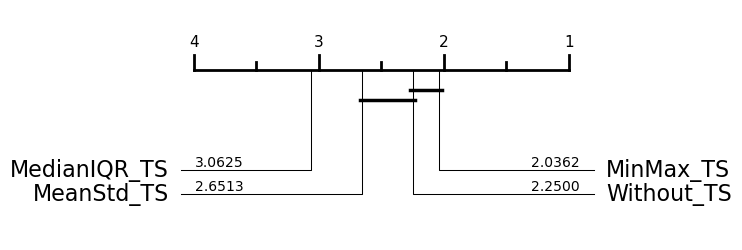

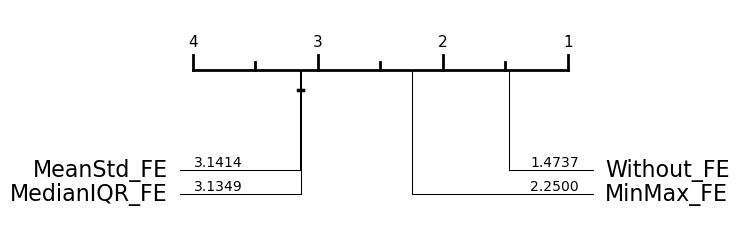

In [10]:
plot_results_normalisation_by_window_size(32, res_mini_noNorm_svdb, res_mini_MinMax_norm_svdb, res_mini_MedianIQR_norm_svdb, res_mini_MeanStd_norm_svdb)

#### Taille de fenêtre 64

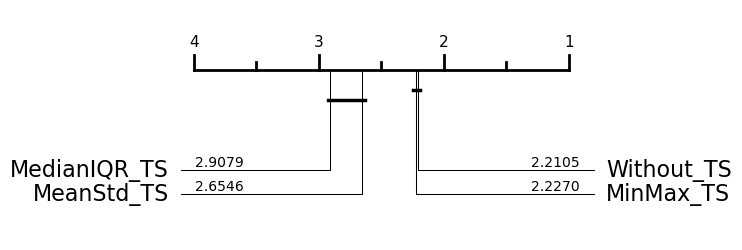

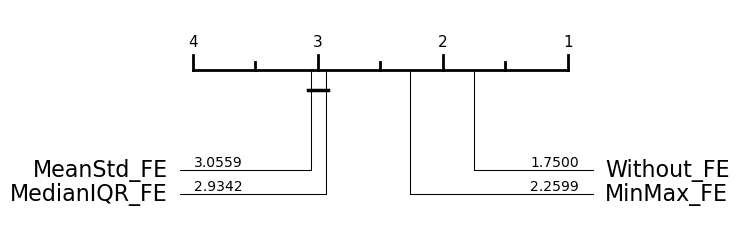

In [11]:
plot_results_normalisation_by_window_size(64, res_mini_noNorm_svdb, res_mini_MinMax_norm_svdb, res_mini_MedianIQR_norm_svdb, res_mini_MeanStd_norm_svdb)

#### Taille de fenêtre 128

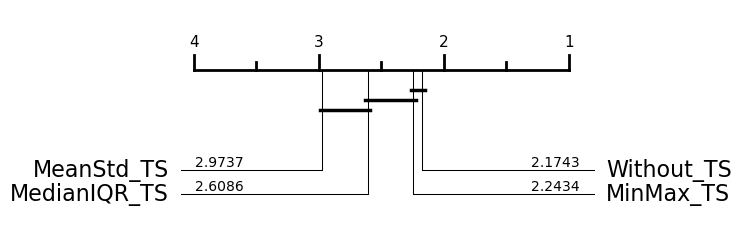

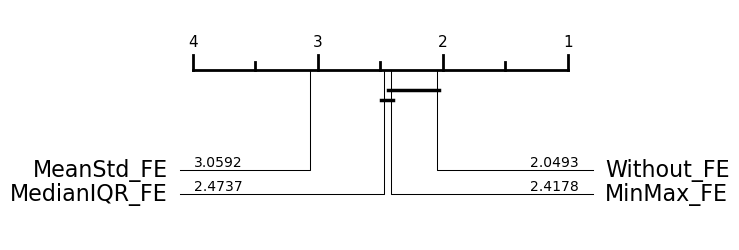

In [12]:
plot_results_normalisation_by_window_size(128, res_mini_noNorm_svdb, res_mini_MinMax_norm_svdb, res_mini_MedianIQR_norm_svdb, res_mini_MeanStd_norm_svdb)

#### Taille de fenêtre 256

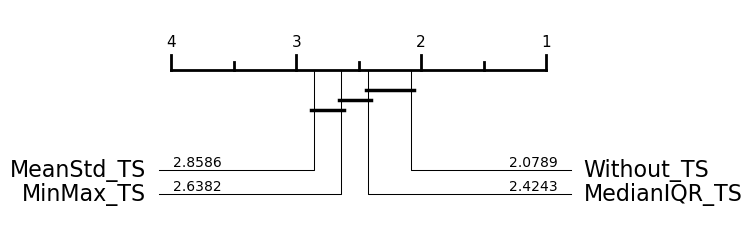

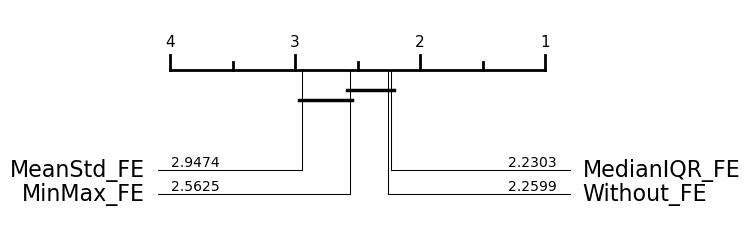

In [13]:
plot_results_normalisation_by_window_size(256, res_mini_noNorm_svdb, res_mini_MinMax_norm_svdb, res_mini_MedianIQR_norm_svdb, res_mini_MeanStd_norm_svdb)

### Jeu de données AIOPS + NormA

In [14]:
json_mini_noNorm_aiops_norma= "resultats/results_aiops_norma/minimal_no_norm_auc.json"
res_mini_noNorm_aiops_norma = concat_res_to_data(json_mini_noNorm_aiops_norma)
res_mini_noNorm_aiops_norma

,32,64,128,256,32,64,128,256,32,64,...,128,256,32,64,128,256,32,64,128,256
IF_TS,0.704,0.701,0.680,0.700,0.921,0.862,0.817,0.752,0.964,0.946,...,0.398,0.417,0.667,0.663,0.657,0.636,0.395,0.372,0.382,0.489
LOF_TS,0.456,0.530,0.520,0.534,0.447,0.483,0.494,0.538,0.523,0.550,...,0.591,0.471,0.677,0.499,0.495,0.508,0.382,0.340,0.371,0.420
IF_FE,0.781,0.766,0.745,0.718,0.959,0.934,0.874,0.853,0.986,0.979,...,0.542,0.512,0.571,0.600,0.610,0.594,0.397,0.403,0.470,0.501
LOF_FE,0.529,0.536,0.488,0.470,0.495,0.516,0.532,0.546,0.523,0.546,...,0.506,0.509,0.616,0.593,0.550,0.505,0.536,0.473,0.528,0.575


In [15]:
json_mini_MinMax_norm_aiops_norma = "resultats/results_aiops_norma/minimal_MinMax_norm_auc.json"
res_mini_MinMax_norm_aiops_norma = concat_res_to_data(json_mini_MinMax_norm_aiops_norma) 
res_mini_MinMax_norm_aiops_norma

,32,64,128,256,32,64,128,256,32,64,...,128,256,32,64,128,256,32,64,128,256
IF_TS,0.459,0.428,0.420,0.513,0.825,0.865,0.821,0.618,0.552,0.598,...,0.539,0.448,0.662,0.726,0.630,0.533,0.442,0.432,0.437,0.455
LOF_TS,0.679,0.500,0.472,0.566,0.462,0.368,0.297,0.283,0.455,0.408,...,0.498,0.513,0.721,0.598,0.528,0.488,0.423,0.350,0.358,0.298
IF_FE,0.414,0.572,0.669,0.617,0.895,0.944,0.968,0.951,0.617,0.660,...,0.590,0.518,0.622,0.726,0.679,0.525,0.557,0.465,0.423,0.432
LOF_FE,0.560,0.518,0.520,0.520,0.620,0.589,0.546,0.525,0.556,0.551,...,0.479,0.488,0.659,0.604,0.690,0.518,0.518,0.458,0.493,0.486


In [16]:
json_mini_MedianIQR_norm_aiops_norma = "resultats/results_aiops_norma/minimal_MedianIQR_norm_auc.json"
res_mini_MedianIQR_norm_aiops_norma = concat_res_to_data(json_mini_MedianIQR_norm_aiops_norma) 
res_mini_MedianIQR_norm_aiops_norma

,32,64,128,256,32,64,128,256,32,64,...,128,256,32,64,128,256,32,64,128,256
IF_TS,0.502,0.408,0.354,0.351,0.605,0.643,0.695,0.645,0.569,0.592,...,0.625,0.626,0.662,0.726,0.630,0.533,0.398,0.382,0.322,0.480
LOF_TS,0.481,0.403,0.374,0.500,0.480,0.545,0.532,0.505,0.567,0.484,...,0.539,0.533,0.721,0.598,0.528,0.488,0.386,0.349,0.284,0.274
IF_FE,0.553,0.534,0.641,0.646,0.882,0.946,0.966,0.943,0.621,0.667,...,0.599,0.602,0.622,0.726,0.679,0.525,0.548,0.449,0.385,0.325
LOF_FE,0.538,0.566,0.562,0.540,0.619,0.610,0.591,0.582,0.527,0.526,...,0.455,0.490,0.659,0.604,0.690,0.518,0.543,0.496,0.464,0.512


In [17]:
json_mini_MeanStd_norm_aiops_norma = "resultats/results_aiops_norma/minimal_MeanStd_norm_auc.json"
res_mini_MeanStd_norm_aiops_norma = concat_res_to_data(json_mini_MeanStd_norm_aiops_norma)
res_mini_MeanStd_norm_aiops_norma

,32,64,128,256,32,64,128,256,32,64,...,128,256,32,64,128,256,32,64,128,256
IF_TS,0.496,0.385,0.310,0.279,0.112,0.085,0.137,0.144,0.416,0.407,...,0.602,0.557,0.602,0.736,0.684,0.554,0.448,0.432,0.484,0.592
LOF_TS,0.624,0.530,0.434,0.482,0.260,0.314,0.358,0.375,0.429,0.347,...,0.484,0.530,0.723,0.615,0.536,0.518,0.408,0.356,0.351,0.317
IF_FE,0.436,0.566,0.643,0.574,0.924,0.955,0.975,0.968,0.623,0.672,...,0.594,0.503,0.623,0.733,0.694,0.534,0.552,0.441,0.412,0.401
LOF_FE,0.595,0.609,0.579,0.536,0.534,0.563,0.556,0.550,0.558,0.569,...,0.473,0.525,0.713,0.647,0.598,0.578,0.503,0.481,0.462,0.488


#### Taille de fenêtre 32

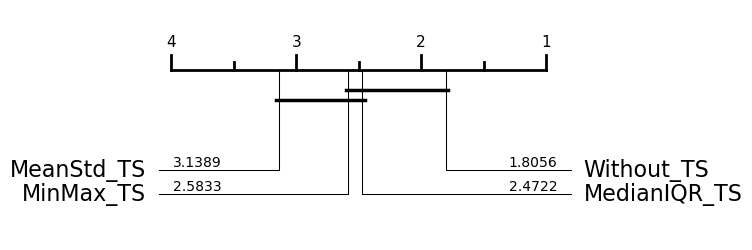

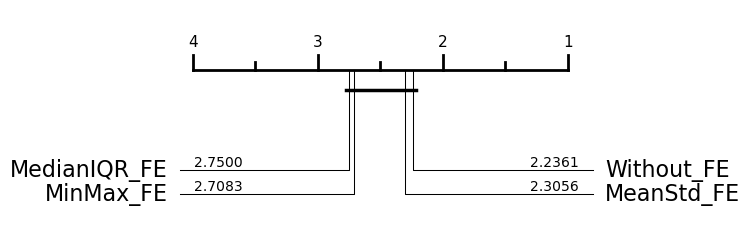

In [18]:
plot_results_normalisation_by_window_size(32, res_mini_noNorm_aiops_norma, res_mini_MinMax_norm_aiops_norma,
                       res_mini_MedianIQR_norm_aiops_norma, res_mini_MeanStd_norm_aiops_norma)

#### Taille de fenêtre 64

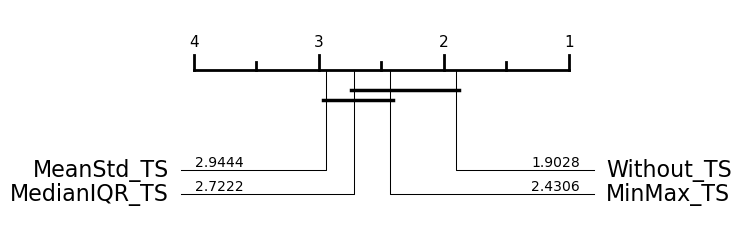

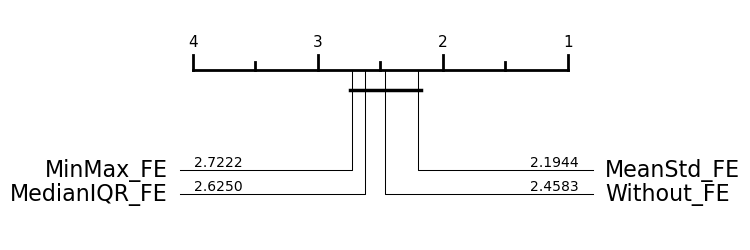

In [19]:
plot_results_normalisation_by_window_size(64, res_mini_noNorm_aiops_norma, res_mini_MinMax_norm_aiops_norma,
                       res_mini_MedianIQR_norm_aiops_norma, res_mini_MeanStd_norm_aiops_norma)

#### Taille de fenêtre 128

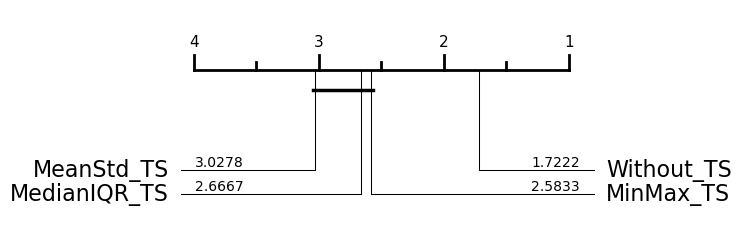

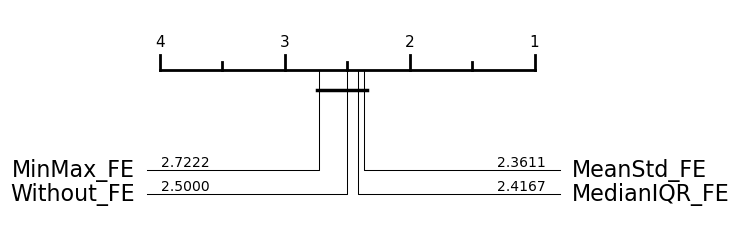

In [20]:
plot_results_normalisation_by_window_size(128, res_mini_noNorm_aiops_norma, res_mini_MinMax_norm_aiops_norma,
                       res_mini_MedianIQR_norm_aiops_norma, res_mini_MeanStd_norm_aiops_norma)

#### Taille de fenêtre 256

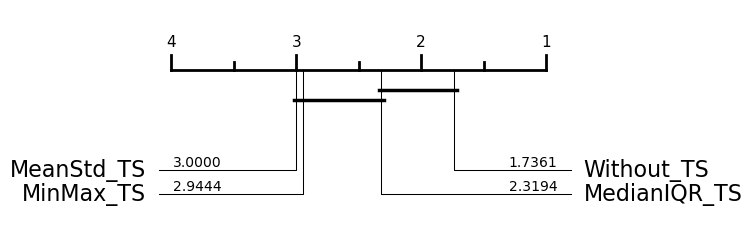

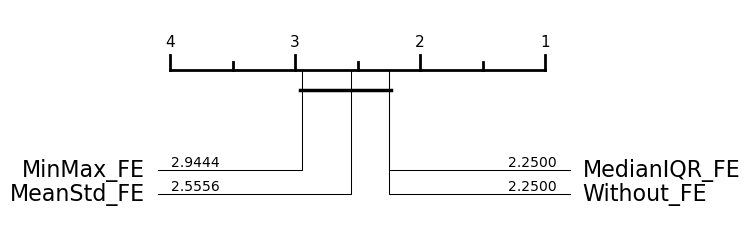

In [21]:
plot_results_normalisation_by_window_size(256, res_mini_noNorm_aiops_norma, res_mini_MinMax_norm_aiops_norma,
                       res_mini_MedianIQR_norm_aiops_norma, res_mini_MeanStd_norm_aiops_norma)

## Significativité des rangs moyens des AUC (par algorithmes)

In [22]:
def comparison_TS_FE(ws, list_selected_index_col, path):    
    """
    Création d'une table de données ne contenant que deux colonnes : 'TS' et 'FE' associés à l'utilisation d'un même algorithme ('IF' ou 'LOF') 
    et d'une seule taille de fenêtre.

    ws : taille de la fenêtre étudiée.
    list_selected_index_col : liste des indices des colonnes à sélectionner.
    path : nom du fichier json contenant les résultats (AUC-ROC).
    """
    res = concat_res_to_data(path) 
    res = res.filter(like=f'{ws}')
    res.columns = list(range(len(res.columns)))
    res = res.T
    res = res.iloc[:,list_selected_index_col]
    res.columns = ["TS", "FE"]
    return res

In [23]:
# Code essentiellement issu de la bibliothèque aeon 
def rank_performance_TS_FE(data):    
    """
    Fonction permettant de calculer et de comparer les rangs moyens des procédés 'TS' et 'FE' utilisés.

    data : table de données contenant les résultats à comparer (par colonne).
    """    
    labels = ["TS", "FE"]
    ranks = rankdata(-1 * data, axis=1)
    ordered_avg_ranks = ranks.mean(axis=0)

    ordered_labels_ranks = np.array(
        [(labels, float(r)) for r, labels in sorted(zip(ordered_avg_ranks, labels))],
        dtype=object,
    )
    ordered_labels = np.array([la for la, _ in ordered_labels_ranks], dtype=str)
    ordered_avg_ranks = np.array([r for _, r in ordered_labels_ranks], dtype=np.float32)
    return [ordered_labels.tolist(), ordered_avg_ranks.tolist()]

#### Lecture des résultats

In [24]:
name_file_svdb_efficient_results = "resultats/results_svdb/efficient_no_norm_auc.json"
name_file_aiops_norma_efficient_results = "resultats/results_aiops_norma/efficient_no_norm_auc.json"
name_file_nab_efficient_results = "resultats/results_nab/efficient_no_norm_auc.json"
name_file_ucr_efficient_results = "resultats/results_ucr/efficient_no_norm_auc.json"

#### Algorithme isolation Forest

In [25]:
index_IF_results = [0,2]

svdb_32_IF = comparison_TS_FE(32, index_IF_results, name_file_svdb_efficient_results)
svdb_64_IF = comparison_TS_FE(64, index_IF_results, name_file_svdb_efficient_results)
svdb_128_IF = comparison_TS_FE(128, index_IF_results, name_file_svdb_efficient_results)
svdb_256_IF = comparison_TS_FE(256, index_IF_results, name_file_svdb_efficient_results)

aiops_norma_32_IF = comparison_TS_FE(32, index_IF_results, name_file_aiops_norma_efficient_results)
aiops_norma_64_IF = comparison_TS_FE(64, index_IF_results, name_file_aiops_norma_efficient_results)
aiops_norma_128_IF = comparison_TS_FE(128, index_IF_results, name_file_aiops_norma_efficient_results)
aiops_norma_256_IF = comparison_TS_FE(256, index_IF_results, name_file_aiops_norma_efficient_results)

nab_32_IF = comparison_TS_FE(32, index_IF_results, name_file_nab_efficient_results)
nab_64_IF = comparison_TS_FE(64, index_IF_results, name_file_nab_efficient_results)
nab_128_IF = comparison_TS_FE(128, index_IF_results, name_file_nab_efficient_results)
nab_256_IF = comparison_TS_FE(256, index_IF_results, name_file_nab_efficient_results)

ucr_32_IF = comparison_TS_FE(32, index_IF_results, name_file_ucr_efficient_results)
ucr_64_IF = comparison_TS_FE(64, index_IF_results, name_file_ucr_efficient_results)
ucr_128_IF = comparison_TS_FE(128, index_IF_results, name_file_ucr_efficient_results)
ucr_256_IF = comparison_TS_FE(256, index_IF_results, name_file_ucr_efficient_results)

##### Valeurs des rangs moyens et p-values du test de Wilcoxon

In [26]:
print('Résultats issus du jeu de données SVDB :')
print("RANK :", rank_performance_TS_FE(svdb_32_IF)[0] , np.round(rank_performance_TS_FE(svdb_32_IF)[1],3),
      "   P-VALUE :", '{:0.3e}'.format(wilcoxon(svdb_32_IF["TS"] - svdb_32_IF["FE"])[1]))
print("RANK :", rank_performance_TS_FE(svdb_64_IF)[0] , np.round(rank_performance_TS_FE(svdb_64_IF)[1],3),
      "   P-VALUE :", '{:0.3e}'.format(wilcoxon(svdb_64_IF["TS"] - svdb_64_IF["FE"])[1]))
print("RANK :", rank_performance_TS_FE(svdb_128_IF)[0] , np.round(rank_performance_TS_FE(svdb_128_IF)[1],3),
      "   P-VALUE :", '{:0.3e}'.format(wilcoxon(svdb_128_IF["TS"] - svdb_128_IF["FE"])[1]))
print("RANK :", rank_performance_TS_FE(svdb_256_IF)[0] , np.round(rank_performance_TS_FE(svdb_256_IF)[1],3),
      "   P-VALUE :", '{:0.3e}'.format(wilcoxon(svdb_256_IF["TS"] - svdb_256_IF["FE"])[1]), "\n")

print('Résultats issus du jeu de données AIOPS + NormA :')
print("RANK :", rank_performance_TS_FE(aiops_norma_32_IF)[0] , np.round(rank_performance_TS_FE(aiops_norma_32_IF)[1],3),
      "   P-VALUE :", '{:0.3e}'.format(wilcoxon(aiops_norma_32_IF["TS"] - aiops_norma_32_IF["FE"])[1]))
print("RANK :", rank_performance_TS_FE(aiops_norma_64_IF)[0] , np.round(rank_performance_TS_FE(aiops_norma_64_IF)[1],3),
      "   P-VALUE :", '{:0.3e}'.format(wilcoxon(aiops_norma_64_IF["TS"] - aiops_norma_64_IF["FE"])[1]))
print("RANK :", rank_performance_TS_FE(aiops_norma_128_IF)[0] , np.round(rank_performance_TS_FE(aiops_norma_128_IF)[1],3),
      "   P-VALUE :", '{:0.3e}'.format(wilcoxon(aiops_norma_128_IF["TS"] - aiops_norma_128_IF["FE"])[1]))
print("RANK :", rank_performance_TS_FE(aiops_norma_256_IF)[0] , np.round(rank_performance_TS_FE(aiops_norma_256_IF)[1],3),
      "   P-VALUE :", '{:0.3e}'.format(wilcoxon(aiops_norma_256_IF["TS"] - aiops_norma_256_IF["FE"])[1]), "\n")

print('Résultats issus du jeu de données NAB :')
print("RANK :", rank_performance_TS_FE(nab_32_IF)[0] , np.round(rank_performance_TS_FE(nab_32_IF)[1],3),
      "   P-VALUE :", '{:0.3e}'.format(wilcoxon(nab_32_IF["TS"] - nab_32_IF["FE"])[1]))
print("RANK :", rank_performance_TS_FE(nab_64_IF)[0] , np.round(rank_performance_TS_FE(nab_64_IF)[1],3),
      "   P-VALUE :", '{:0.3e}'.format(wilcoxon(nab_64_IF["TS"] - nab_64_IF["FE"])[1]))
print("RANK :", rank_performance_TS_FE(nab_128_IF)[0] , np.round(rank_performance_TS_FE(nab_128_IF)[1],3),
      "   P-VALUE :", '{:0.3e}'.format(wilcoxon(nab_128_IF["TS"] - nab_128_IF["FE"])[1]))
print("RANK :", rank_performance_TS_FE(nab_256_IF)[0] , np.round(rank_performance_TS_FE(nab_256_IF)[1],3),
      "   P-VALUE :", '{:0.3e}'.format(wilcoxon(nab_256_IF["TS"] - nab_256_IF["FE"])[1]), "\n")

print('Résultats issus du jeu de données UCR :')
print("RANK :", rank_performance_TS_FE(ucr_32_IF)[0] , np.round(rank_performance_TS_FE(ucr_32_IF)[1],3),
      "   P-VALUE :", '{:0.3e}'.format(wilcoxon(ucr_32_IF["TS"] - ucr_32_IF["FE"])[1]))
print("RANK :", rank_performance_TS_FE(ucr_64_IF)[0] , np.round(rank_performance_TS_FE(ucr_64_IF)[1],3),
      "   P-VALUE :", '{:0.3e}'.format(wilcoxon(ucr_64_IF["TS"] - ucr_64_IF["FE"])[1]))
print("RANK :", rank_performance_TS_FE(ucr_128_IF)[0] , np.round(rank_performance_TS_FE(ucr_128_IF)[1],3),
      "   P-VALUE :", '{:0.3e}'.format(wilcoxon(ucr_128_IF["TS"] - ucr_128_IF["FE"])[1]))
print("RANK :", rank_performance_TS_FE(ucr_256_IF)[0] , np.round(rank_performance_TS_FE(ucr_256_IF)[1],3),
      "   P-VALUE :", '{:0.3e}'.format(wilcoxon(ucr_256_IF["TS"] - ucr_256_IF["FE"])[1]))

Résultats issus du jeu de données SVDB :
RANK : ['FE', 'TS'] [1.118 1.882]    P-VALUE : 1.522e-12
RANK : ['FE', 'TS'] [1.145 1.855]    P-VALUE : 5.375e-09
RANK : ['FE', 'TS'] [1.158 1.842]    P-VALUE : 5.553e-10
RANK : ['FE', 'TS'] [1.408 1.592]    P-VALUE : 1.161e-01 

Résultats issus du jeu de données AIOPS + NormA :
RANK : ['FE', 'TS'] [1.111 1.889]    P-VALUE : 1.930e-03
RANK : ['FE', 'TS'] [1.222 1.778]    P-VALUE : 1.930e-03
RANK : ['FE', 'TS'] [1.222 1.778]    P-VALUE : 1.930e-03
RANK : ['FE', 'TS'] [1.167 1.833]    P-VALUE : 4.745e-03 

Résultats issus du jeu de données NAB :
RANK : ['FE', 'TS'] [1.348 1.652]    P-VALUE : 5.059e-02
RANK : ['FE', 'TS'] [1.37 1.63]    P-VALUE : 1.727e-02
RANK : ['FE', 'TS'] [1.326 1.674]    P-VALUE : 5.525e-03
RANK : ['FE', 'TS'] [1.359 1.641]    P-VALUE : 1.723e-02 

Résultats issus du jeu de données UCR :
RANK : ['FE', 'TS'] [1.174 1.826]    P-VALUE : 2.581e-29
RANK : ['FE', 'TS'] [1.156 1.844]    P-VALUE : 9.264e-32
RANK : ['FE', 'TS'] [1.152 

#### Algorithme Local Outlier Factor (LOF)

In [27]:
index_LOF_results = [1,3]

svdb_32_LOF = comparison_TS_FE(32, index_LOF_results, name_file_svdb_efficient_results)
svdb_64_LOF = comparison_TS_FE(64, index_LOF_results, name_file_svdb_efficient_results)
svdb_128_LOF = comparison_TS_FE(128, index_LOF_results, name_file_svdb_efficient_results)
svdb_256_LOF = comparison_TS_FE(256, index_LOF_results, name_file_svdb_efficient_results)

aiops_norma_32_LOF = comparison_TS_FE(32, index_LOF_results, name_file_aiops_norma_efficient_results)
aiops_norma_64_LOF = comparison_TS_FE(64, index_LOF_results, name_file_aiops_norma_efficient_results)
aiops_norma_128_LOF = comparison_TS_FE(128, index_LOF_results, name_file_aiops_norma_efficient_results)
aiops_norma_256_LOF = comparison_TS_FE(256, index_LOF_results, name_file_aiops_norma_efficient_results)

nab_32_LOF = comparison_TS_FE(32, index_LOF_results, name_file_nab_efficient_results)
nab_64_LOF = comparison_TS_FE(64, index_LOF_results, name_file_nab_efficient_results)
nab_128_LOF = comparison_TS_FE(128, index_LOF_results, name_file_nab_efficient_results)
nab_256_LOF = comparison_TS_FE(256, index_LOF_results, name_file_nab_efficient_results)

ucr_32_LOF = comparison_TS_FE(32, index_LOF_results, name_file_ucr_efficient_results)
ucr_64_LOF = comparison_TS_FE(64, index_LOF_results, name_file_ucr_efficient_results)
ucr_128_LOF = comparison_TS_FE(128, index_LOF_results, name_file_ucr_efficient_results)
ucr_256_LOF = comparison_TS_FE(256, index_LOF_results, name_file_ucr_efficient_results)

In [28]:
print('Résultats issus du jeu de données SVDB :')
print("RANK :", rank_performance_TS_FE(svdb_32_LOF)[0] , np.round(rank_performance_TS_FE(svdb_32_LOF)[1],3),
      "   P-VALUE :", '{:0.3e}'.format(wilcoxon(svdb_32_LOF["TS"] - svdb_32_LOF["FE"])[1]))
print("RANK :", rank_performance_TS_FE(svdb_64_LOF)[0] , np.round(rank_performance_TS_FE(svdb_64_LOF)[1],3),
      "   P-VALUE :", '{:0.3e}'.format(wilcoxon(svdb_64_LOF["TS"] - svdb_64_LOF["FE"])[1]))
print("RANK :", rank_performance_TS_FE(svdb_128_LOF)[0] , np.round(rank_performance_TS_FE(svdb_128_LOF)[1],3),
      "   P-VALUE :", '{:0.3e}'.format(wilcoxon(svdb_128_LOF["TS"] - svdb_128_LOF["FE"])[1]))
print("RANK :", rank_performance_TS_FE(svdb_256_LOF)[0] , np.round(rank_performance_TS_FE(svdb_256_LOF)[1],3),
      "   P-VALUE :", '{:0.3e}'.format(wilcoxon(svdb_256_LOF["TS"] - svdb_256_LOF["FE"])[1]), "\n")

print('Résultats issus du jeu de données AIOPS + NormA :')
print("RANK :", rank_performance_TS_FE(aiops_norma_32_LOF)[0] , np.round(rank_performance_TS_FE(aiops_norma_32_LOF)[1],3),
      "   P-VALUE :", '{:0.3e}'.format(wilcoxon(aiops_norma_32_LOF["TS"] - aiops_norma_32_LOF["FE"])[1]))
print("RANK :", rank_performance_TS_FE(aiops_norma_64_LOF)[0] , np.round(rank_performance_TS_FE(aiops_norma_64_LOF)[1],3),
      "   P-VALUE :", '{:0.3e}'.format(wilcoxon(aiops_norma_64_LOF["TS"] - aiops_norma_64_LOF["FE"])[1]))
print("RANK :", rank_performance_TS_FE(aiops_norma_128_LOF)[0] , np.round(rank_performance_TS_FE(aiops_norma_128_LOF)[1],3),
      "   P-VALUE :", '{:0.3e}'.format(wilcoxon(aiops_norma_128_LOF["TS"] - aiops_norma_128_LOF["FE"])[1]))
print("RANK :", rank_performance_TS_FE(aiops_norma_256_LOF)[0] , np.round(rank_performance_TS_FE(aiops_norma_256_LOF)[1],3),
      "   P-VALUE :", '{:0.3e}'.format(wilcoxon(aiops_norma_256_LOF["TS"] - aiops_norma_256_LOF["FE"])[1]), "\n")

print('Résultats issus du jeu de données NAB :')
print("RANK :", rank_performance_TS_FE(nab_32_LOF)[0] , np.round(rank_performance_TS_FE(nab_32_LOF)[1],3),
      "   P-VALUE :", '{:0.3e}'.format(wilcoxon(nab_32_LOF["TS"] - nab_32_LOF["FE"])[1]))
print("RANK :", rank_performance_TS_FE(nab_64_LOF)[0] , np.round(rank_performance_TS_FE(nab_64_LOF)[1],3),
      "   P-VALUE :", '{:0.3e}'.format(wilcoxon(nab_64_LOF["TS"] - nab_64_LOF["FE"])[1]))
print("RANK :", rank_performance_TS_FE(nab_128_LOF)[0] , np.round(rank_performance_TS_FE(nab_128_LOF)[1],3),
      "   P-VALUE :", '{:0.3e}'.format(wilcoxon(nab_128_LOF["TS"] - nab_128_LOF["FE"])[1]))
print("RANK :", rank_performance_TS_FE(nab_256_LOF)[0] , np.round(rank_performance_TS_FE(nab_256_LOF)[1],3),
      "   P-VALUE :", '{:0.3e}'.format(wilcoxon(nab_256_LOF["TS"] - nab_256_LOF["FE"])[1]), "\n")

print('Résultats issus du jeu de données UCR :')
print("RANK :", rank_performance_TS_FE(ucr_32_LOF)[0] , np.round(rank_performance_TS_FE(ucr_32_LOF)[1],3),
      "   P-VALUE :", '{:0.3e}'.format(wilcoxon(ucr_32_LOF["TS"] - ucr_32_LOF["FE"])[1]))
print("RANK :", rank_performance_TS_FE(ucr_64_LOF)[0] , np.round(rank_performance_TS_FE(ucr_64_LOF)[1],3),
      "   P-VALUE :", '{:0.3e}'.format(wilcoxon(ucr_64_LOF["TS"] - ucr_64_LOF["FE"])[1]))
print("RANK :", rank_performance_TS_FE(ucr_128_LOF)[0] , np.round(rank_performance_TS_FE(ucr_128_LOF)[1],3),
      "   P-VALUE :", '{:0.3e}'.format(wilcoxon(ucr_128_LOF["TS"] - ucr_128_LOF["FE"])[1]))
print("RANK :", rank_performance_TS_FE(ucr_256_LOF)[0] , np.round(rank_performance_TS_FE(ucr_256_LOF)[1],3),
      "   P-VALUE :", '{:0.3e}'.format(wilcoxon(ucr_256_LOF["TS"] - ucr_256_LOF["FE"])[1]))

Résultats issus du jeu de données SVDB :
RANK : ['TS', 'FE'] [1.329 1.671]    P-VALUE : 2.066e-03
RANK : ['TS', 'FE'] [1.48 1.52]    P-VALUE : 4.454e-01
RANK : ['FE', 'TS'] [1.25 1.75]    P-VALUE : 2.490e-06
RANK : ['FE', 'TS'] [1.316 1.684]    P-VALUE : 5.541e-06 

Résultats issus du jeu de données AIOPS + NormA :
RANK : ['FE', 'TS'] [1.444 1.556]    P-VALUE : 8.317e-01
RANK : ['FE', 'TS'] [1.444 1.556]    P-VALUE : 7.660e-01
RANK : ['TS', 'FE'] [1.417 1.583]    P-VALUE : 4.925e-01
RANK : ['TS', 'FE'] [1.389 1.611]    P-VALUE : 1.674e-01 

Résultats issus du jeu de données NAB :
RANK : ['TS', 'FE'] [1.261 1.739]    P-VALUE : 8.504e-04
RANK : ['TS', 'FE'] [1.261 1.739]    P-VALUE : 7.430e-05
RANK : ['TS', 'FE'] [1.217 1.783]    P-VALUE : 1.261e-04
RANK : ['TS', 'FE'] [1.283 1.717]    P-VALUE : 3.163e-03 

Résultats issus du jeu de données UCR :
RANK : ['TS', 'FE'] [1.156 1.844]    P-VALUE : 5.159e-22
RANK : ['TS', 'FE'] [1.17 1.83]    P-VALUE : 7.227e-26
RANK : ['TS', 'FE'] [1.223 1.77

## Synthèse des résultats : Critical difference diagram

In [29]:
svdb_cdd = concat_res_to_data(name_file_svdb_efficient_results).T
aiops_norma_cdd = concat_res_to_data(name_file_aiops_norma_efficient_results).T
nab_cdd = concat_res_to_data(name_file_nab_efficient_results).T
ucr_cdd = concat_res_to_data(name_file_ucr_efficient_results).T

(<Figure size 600x230 with 1 Axes>, <Axes: >)

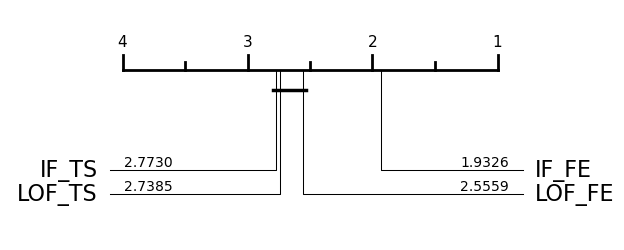

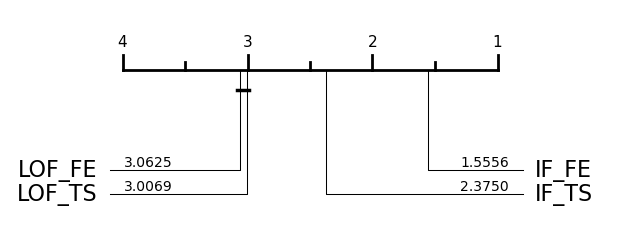

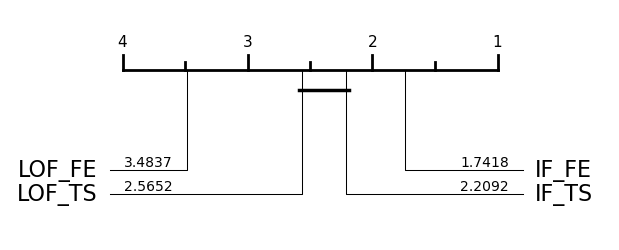

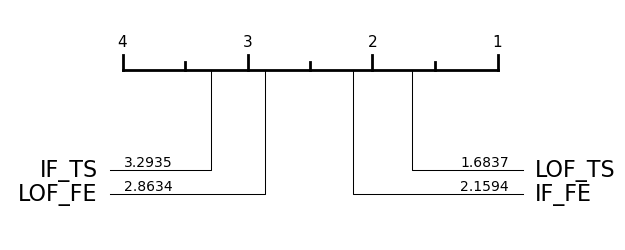

In [30]:
plot_critical_difference(svdb_cdd.values,  list(svdb_cdd.columns), alpha=0.05,
                          test="nemenyi", correction=None)   
plot_critical_difference(aiops_norma_cdd.values,  list(aiops_norma_cdd.columns), alpha=0.05,
                          test="nemenyi", correction=None)   
plot_critical_difference(nab_cdd.values,  list(nab_cdd.columns), alpha=0.05,
                          test="nemenyi", correction=None)   
plot_critical_difference(ucr_cdd.values,  list(ucr_cdd.columns), alpha=0.05,
                          test="nemenyi", correction=None)  

Les valeurs des listes suivantes sont calculées sur les AUC et correspondent dans l'ordre à : **[IF_TS, LOF_TS, IF_FE, LOF_FE]**.

In [31]:
print('Résultats issus du jeu de données SVDB :')
print("MOYENNE    :", round(svdb_cdd.mean(axis=0),3).tolist())
print("ECART-TYPE :", round(svdb_cdd.std(axis=0),3).tolist(), "\n")

print('Résultats issus du jeu de données AIOPS + NormA :')
print("MOYENNE    :", round(aiops_norma_cdd.mean(axis=0),3).tolist())
print("ECART-TYPE :", round(aiops_norma_cdd.std(axis=0),3).tolist(), "\n")

print('Résultats issus du jeu de données NAB :')
print("MOYENNE    :", round(nab_cdd.mean(axis=0),3).tolist())
print("ECART-TYPE :", round(nab_cdd.std(axis=0),3).tolist(), "\n")

print('Résultats issus du jeu de données UCR :')
print("MOYENNE    :", round(ucr_cdd.mean(axis=0),3).tolist())
print("ECART-TYPE :", round(ucr_cdd.std(axis=0),3).tolist(), "\n")

Résultats issus du jeu de données SVDB :
MOYENNE    : [0.638, 0.611, 0.673, 0.632]
ECART-TYPE : [0.118, 0.115, 0.107, 0.112] 

Résultats issus du jeu de données AIOPS + NormA :
MOYENNE    : [0.715, 0.621, 0.808, 0.597]
ECART-TYPE : [0.178, 0.163, 0.187, 0.167] 

Résultats issus du jeu de données NAB :
MOYENNE    : [0.656, 0.599, 0.687, 0.518]
ECART-TYPE : [0.132, 0.154, 0.13, 0.068] 

Résultats issus du jeu de données UCR :
MOYENNE    : [0.586, 0.784, 0.746, 0.648]
ECART-TYPE : [0.221, 0.191, 0.175, 0.142] 



# Matériel supplémentaire

## Tests de plusieurs normalisations des séries (comparaison par algorithmes)

In [32]:
def plot_results_normalisation_by_algorithm(column_name, res_mini_noNorm, res_mini_MinMax_norm, res_mini_MedianIQR_norm, res_mini_MeanStd_norm):
    """
    Affichage des diagrammes de différence critique comparant les performances selon la normalisation effectuée et l'algorithme utilisé.

    column_name : nom de la colonne correspondant à 'algorithme_procédé' (par exemple 'IF_TS').
    res_mini_noNorm : résultats (AUC-ROC) issus de l'utilisation des sous-séquences temporelles non normalisées 
                      et du calcul de 10 features sur chacune d'entre elles.
    res_mini_MinMax_norm : résultats (AUC-ROC) issus de l'utilisation des sous-séquences temporelles normalisées avec la méthode Min-Max
                           et du calcul de 10 features sur chacune d'entre elles.
    res_mini_MedianIQR_norm : résultats (AUC-ROC) issus de l'utilisation des sous-séquences temporelles normalisées avec la méthode Médiane-IQR
                              et du calcul de 10 features sur chacune d'entre elles.
    res_mini_MeanStd_norm : résultats (AUC-ROC) issus de l'utilisation des sous-séquences temporelles normalisées avec la méthode Mean-Std
                            et du calcul de 10 features sur chacune d'entre elles.
    """
    concat_results_norm = pd.concat([res_mini_noNorm.T[column_name], res_mini_MinMax_norm.T[column_name], res_mini_MedianIQR_norm.T[column_name], res_mini_MeanStd_norm.T[column_name]], axis=1)
    concat_results_norm.columns = ["Without", "MinMax", "MedianIQR", "MeanStd"]
    plot_critical_difference(concat_results_norm.values,  list(concat_results_norm.columns), alpha=0.05,
                          test="nemenyi", correction=None)  

### Jeu de données SVDB

#### Algorithme isolation Forest (IF)

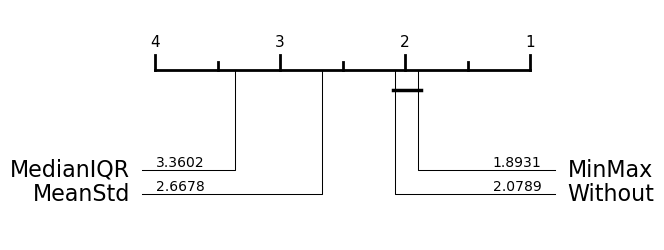

In [33]:
plot_results_normalisation_by_algorithm("IF_TS", res_mini_noNorm_svdb, res_mini_MinMax_norm_svdb, res_mini_MedianIQR_norm_svdb, res_mini_MeanStd_norm_svdb)

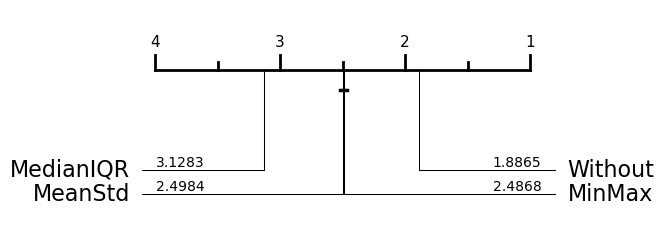

In [34]:
plot_results_normalisation_by_algorithm("IF_FE", res_mini_noNorm_svdb, res_mini_MinMax_norm_svdb, res_mini_MedianIQR_norm_svdb, res_mini_MeanStd_norm_svdb)

#### Algorithme Local Outlier Factor (LOF)

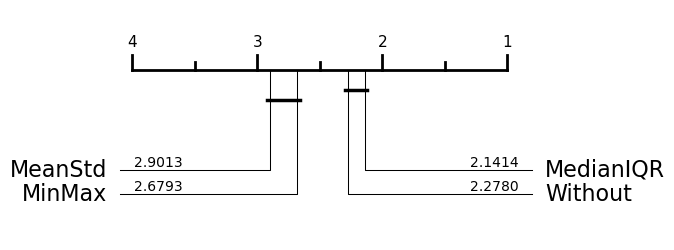

In [35]:
plot_results_normalisation_by_algorithm("LOF_TS", res_mini_noNorm_svdb, res_mini_MinMax_norm_svdb, res_mini_MedianIQR_norm_svdb, res_mini_MeanStd_norm_svdb)

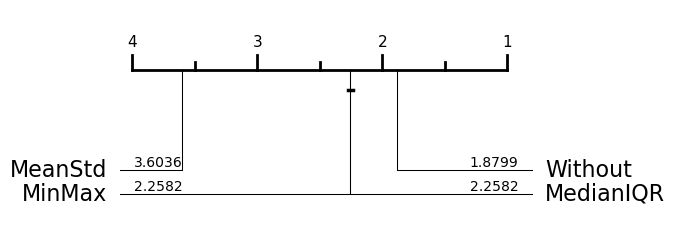

In [36]:
plot_results_normalisation_by_algorithm("LOF_FE", res_mini_noNorm_svdb, res_mini_MinMax_norm_svdb, res_mini_MedianIQR_norm_svdb, res_mini_MeanStd_norm_svdb)

### Jeu de données AIOPS + NormA

#### Algorithme isolation Forest (IF)

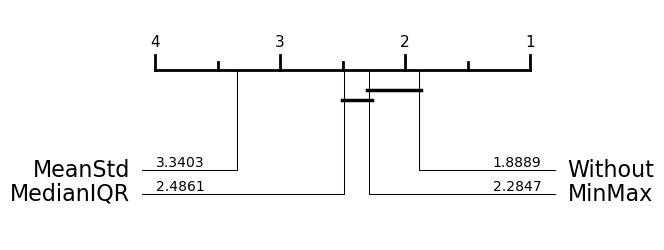

In [37]:
plot_results_normalisation_by_algorithm("IF_TS", res_mini_noNorm_aiops_norma, res_mini_MinMax_norm_aiops_norma, res_mini_MedianIQR_norm_aiops_norma, res_mini_MeanStd_norm_aiops_norma)

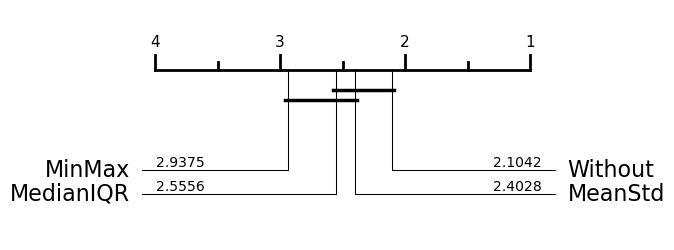

In [38]:
plot_results_normalisation_by_algorithm("IF_FE", res_mini_noNorm_aiops_norma, res_mini_MinMax_norm_aiops_norma, res_mini_MedianIQR_norm_aiops_norma, res_mini_MeanStd_norm_aiops_norma)

#### Algorithme Local Outlier Factor (LOF)

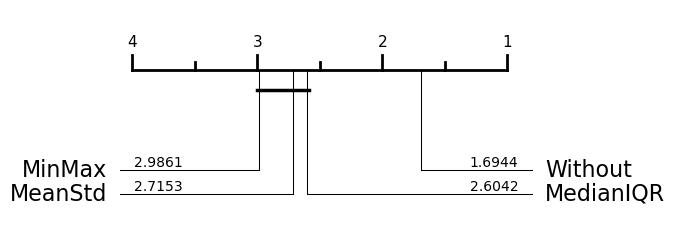

In [39]:
plot_results_normalisation_by_algorithm("LOF_TS", res_mini_noNorm_aiops_norma, res_mini_MinMax_norm_aiops_norma, res_mini_MedianIQR_norm_aiops_norma, res_mini_MeanStd_norm_aiops_norma)

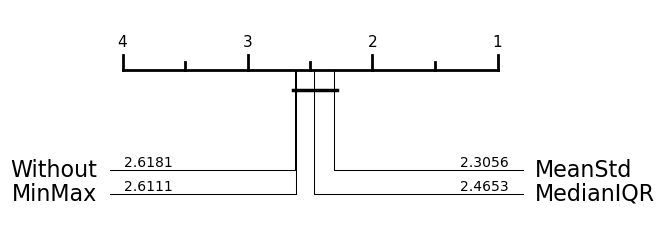

In [40]:
plot_results_normalisation_by_algorithm("LOF_FE", res_mini_noNorm_aiops_norma, res_mini_MinMax_norm_aiops_norma, res_mini_MedianIQR_norm_aiops_norma, res_mini_MeanStd_norm_aiops_norma)

## Détails par taille de fenêtre des performances des algorithmes IF et LOF

In [41]:
columns_comparison = ["IF_TS", "IF_FE", "LOF_TS", "LOF_FE"]

svdb_32 = pd.concat([svdb_32_IF, svdb_32_LOF], axis=1)
svdb_32.columns = columns_comparison
svdb_64 = pd.concat([svdb_64_IF, svdb_64_LOF], axis=1)
svdb_64.columns = columns_comparison
svdb_128 = pd.concat([svdb_128_IF, svdb_128_LOF], axis=1)
svdb_128.columns = columns_comparison
svdb_256 = pd.concat([svdb_256_IF, svdb_256_LOF], axis=1)
svdb_256.columns = columns_comparison

aiops_norma_32 = pd.concat([aiops_norma_32_IF, aiops_norma_32_LOF], axis=1)
aiops_norma_32.columns = columns_comparison
aiops_norma_64 = pd.concat([aiops_norma_64_IF, aiops_norma_64_LOF], axis=1)
aiops_norma_64.columns = columns_comparison
aiops_norma_128 = pd.concat([aiops_norma_128_IF, aiops_norma_128_LOF], axis=1)
aiops_norma_128.columns = columns_comparison
aiops_norma_256 = pd.concat([aiops_norma_256_IF, aiops_norma_256_LOF], axis=1)
aiops_norma_256.columns = columns_comparison

nab_32 = pd.concat([nab_32_IF, nab_32_LOF], axis=1)
nab_32.columns = columns_comparison
nab_64 = pd.concat([nab_64_IF, nab_64_LOF], axis=1)
nab_64.columns = columns_comparison
nab_128 = pd.concat([nab_128_IF, nab_128_LOF], axis=1)
nab_128.columns = columns_comparison
nab_256 = pd.concat([nab_256_IF, nab_256_LOF], axis=1)
nab_256.columns = columns_comparison

ucr_32 = pd.concat([ucr_32_IF, ucr_32_LOF], axis=1)
ucr_32.columns = columns_comparison
ucr_64 = pd.concat([ucr_64_IF, ucr_64_LOF], axis=1)
ucr_64.columns = columns_comparison
ucr_128 = pd.concat([ucr_128_IF, ucr_128_LOF], axis=1)
ucr_128.columns = columns_comparison
ucr_256 = pd.concat([ucr_256_IF, ucr_256_LOF], axis=1)
ucr_256.columns = columns_comparison

Les valeurs des listes suivantes sont calculées sur les AUC et correspondent dans l'ordre à : **[IF_TS, IF_FE, LOF_TS, LOF_FE]**.

### Jeu de données SVDB

#### Taille de fenêtre 32

MOYENNE    : [0.586, 0.621, 0.601, 0.571]
ECART-TYPE : [0.085, 0.084, 0.103, 0.06]


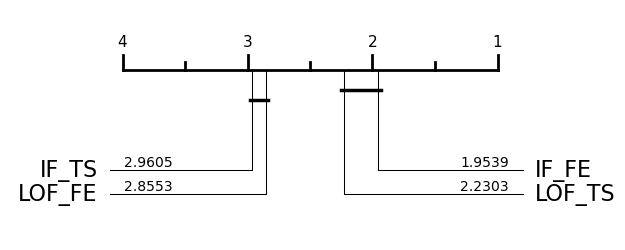

In [42]:
plot_critical_difference(svdb_32.values,  list(svdb_32.columns), alpha=0.05,
                          test="nemenyi", correction=None)   
print("MOYENNE    :", round(svdb_32.mean(axis=0),3).tolist())
print("ECART-TYPE :", round(svdb_32.std(axis=0),3).tolist())

#### Taille de fenêtre 64

MOYENNE    : [0.622, 0.669, 0.603, 0.59]
ECART-TYPE : [0.102, 0.09, 0.113, 0.075]


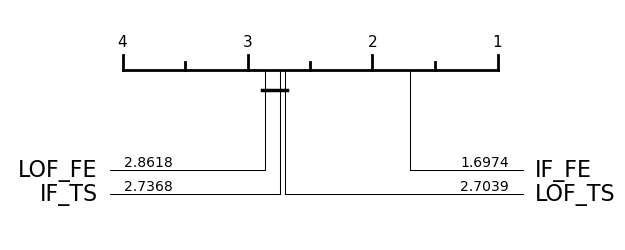

In [43]:
plot_critical_difference(svdb_64.values,  list(svdb_64.columns), alpha=0.05,
                          test="nemenyi", correction=None)   
print("MOYENNE    :", round(svdb_64.mean(axis=0),3).tolist())
print("ECART-TYPE :", round(svdb_64.std(axis=0),3).tolist())

#### Taille de fenêtre 128

MOYENNE    : [0.659, 0.713, 0.6, 0.656]
ECART-TYPE : [0.12, 0.104, 0.117, 0.096]


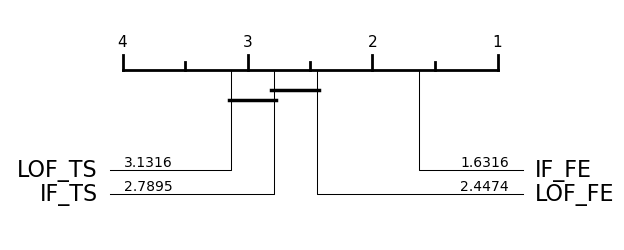

In [44]:
plot_critical_difference(svdb_128.values,  list(svdb_128.columns), alpha=0.05,
                          test="nemenyi", correction=None)   
print("MOYENNE    :", round(svdb_128.mean(axis=0),3).tolist())
print("ECART-TYPE :", round(svdb_128.std(axis=0),3).tolist())

#### Taille de fenêtre 256

MOYENNE    : [0.687, 0.69, 0.639, 0.71]
ECART-TYPE : [0.134, 0.124, 0.123, 0.14]


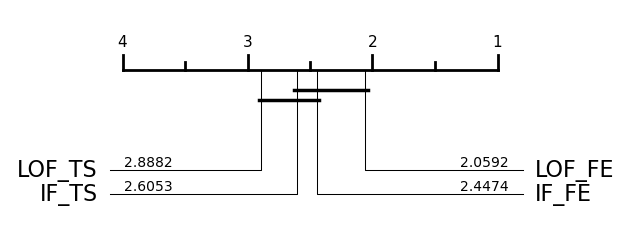

In [45]:
plot_critical_difference(svdb_256.values,  list(svdb_256.columns), alpha=0.05,
                          test="nemenyi", correction=None)   
print("MOYENNE    :", round(svdb_256.mean(axis=0),3).tolist())
print("ECART-TYPE :", round(svdb_256.std(axis=0),3).tolist())

### Jeu de données AIOPS + NormA

#### Taille de fenêtre 32

MOYENNE    : [0.755, 0.814, 0.626, 0.636]
ECART-TYPE : [0.187, 0.203, 0.154, 0.132]


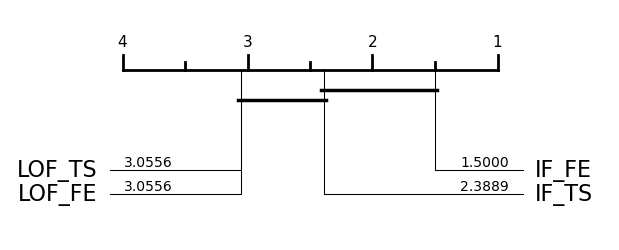

In [46]:
plot_critical_difference(aiops_norma_32.values,  list(aiops_norma_32.columns), alpha=0.05,
                          test="nemenyi", correction=None)   
print("MOYENNE    :", round(aiops_norma_32.mean(axis=0),3).tolist())
print("ECART-TYPE :", round(aiops_norma_32.std(axis=0),3).tolist())

#### Taille de fenêtre 64

MOYENNE    : [0.729, 0.808, 0.617, 0.607]
ECART-TYPE : [0.183, 0.207, 0.167, 0.159]


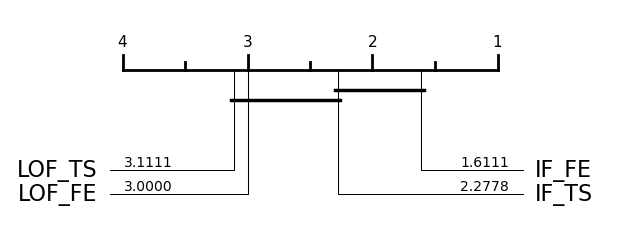

In [47]:
plot_critical_difference(aiops_norma_64.values,  list(aiops_norma_64.columns), alpha=0.05,
                          test="nemenyi", correction=None)   
print("MOYENNE    :", round(aiops_norma_64.mean(axis=0),3).tolist())
print("ECART-TYPE :", round(aiops_norma_64.std(axis=0),3).tolist())

#### Taille de fenêtre 128

MOYENNE    : [0.708, 0.811, 0.604, 0.581]
ECART-TYPE : [0.176, 0.186, 0.18, 0.205]


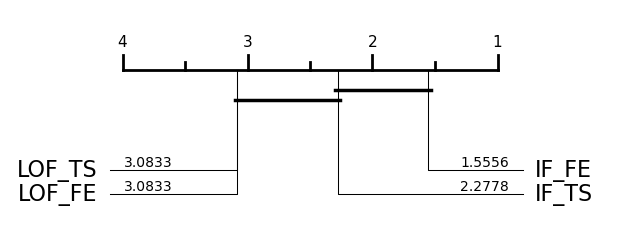

In [48]:
plot_critical_difference(aiops_norma_128.values,  list(aiops_norma_128.columns), alpha=0.05,
                          test="nemenyi", correction=None)   
print("MOYENNE    :", round(aiops_norma_128.mean(axis=0),3).tolist())
print("ECART-TYPE :", round(aiops_norma_128.std(axis=0),3).tolist())

#### Taille de fenêtre 256

MOYENNE    : [0.669, 0.798, 0.638, 0.563]
ECART-TYPE : [0.169, 0.166, 0.16, 0.169]


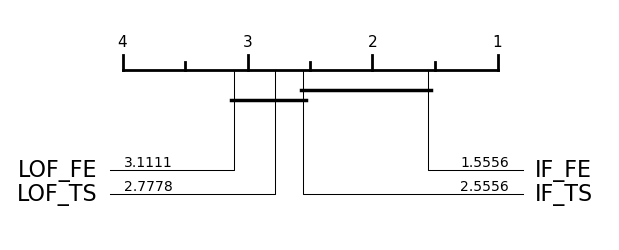

In [49]:
plot_critical_difference(aiops_norma_256.values,  list(aiops_norma_256.columns), alpha=0.05,
                          test="nemenyi", correction=None)   
print("MOYENNE    :", round(aiops_norma_256.mean(axis=0),3).tolist())
print("ECART-TYPE :", round(aiops_norma_256.std(axis=0),3).tolist())

### Jeu de données NAB

#### Taille de fenêtre 32

MOYENNE    : [0.619, 0.637, 0.572, 0.523]
ECART-TYPE : [0.127, 0.114, 0.103, 0.051]


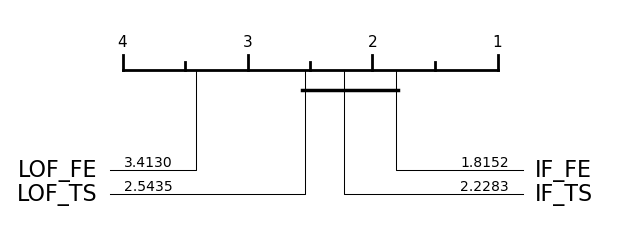

In [50]:
plot_critical_difference(nab_32.values,  list(nab_32.columns), alpha=0.05,
                          test="nemenyi", correction=None)   
print("MOYENNE    :", round(nab_32.mean(axis=0),3).tolist())
print("ECART-TYPE :", round(nab_32.std(axis=0),3).tolist())

#### Taille de fenêtre 64

MOYENNE    : [0.644, 0.67, 0.602, 0.523]
ECART-TYPE : [0.13, 0.11, 0.131, 0.064]


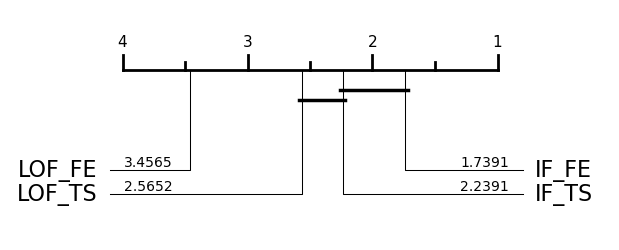

In [51]:
plot_critical_difference(nab_64.values,  list(nab_64.columns), alpha=0.05,
                          test="nemenyi", correction=None)   
print("MOYENNE    :", round(nab_64.mean(axis=0),3).tolist())
print("ECART-TYPE :", round(nab_64.std(axis=0),3).tolist())

#### Taille de fenêtre 128

MOYENNE    : [0.665, 0.707, 0.618, 0.511]
ECART-TYPE : [0.13, 0.12, 0.16, 0.078]


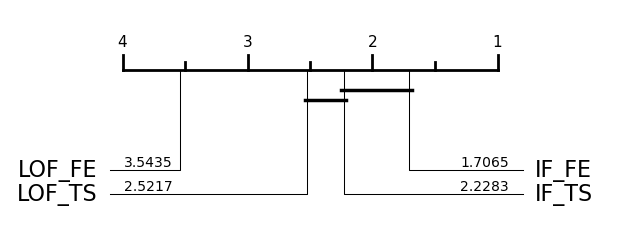

In [52]:
plot_critical_difference(nab_128.values,  list(nab_128.columns), alpha=0.05,
                          test="nemenyi", correction=None)   
print("MOYENNE    :", round(nab_128.mean(axis=0),3).tolist())
print("ECART-TYPE :", round(nab_128.std(axis=0),3).tolist())

#### Taille de fenêtre 256

MOYENNE    : [0.696, 0.733, 0.604, 0.514]
ECART-TYPE : [0.132, 0.156, 0.205, 0.075]


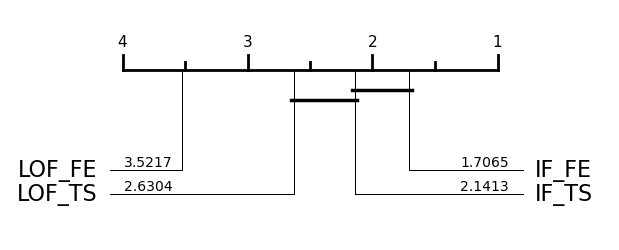

In [53]:
plot_critical_difference(nab_256.values,  list(nab_256.columns), alpha=0.05,
                          test="nemenyi", correction=None)   
print("MOYENNE    :", round(nab_256.mean(axis=0),3).tolist())
print("ECART-TYPE :", round(nab_256.std(axis=0),3).tolist())

### Jeu de données UCR

#### Taille de fenêtre 32

MOYENNE    : [0.588, 0.699, 0.782, 0.675]
ECART-TYPE : [0.2, 0.184, 0.183, 0.131]


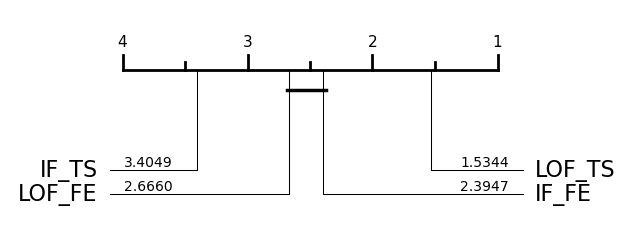

In [54]:
plot_critical_difference(ucr_32.values,  list(ucr_32.columns), alpha=0.05,
                          test="nemenyi", correction=None)   
print("MOYENNE    :", round(ucr_32.mean(axis=0),3).tolist())
print("ECART-TYPE :", round(ucr_32.std(axis=0),3).tolist())

#### Taille de fenêtre 64

MOYENNE    : [0.583, 0.735, 0.807, 0.662]
ECART-TYPE : [0.213, 0.177, 0.185, 0.135]


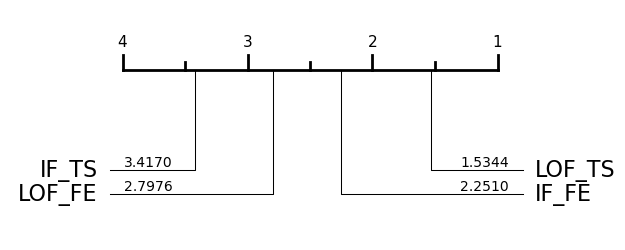

In [55]:
plot_critical_difference(ucr_64.values,  list(ucr_64.columns), alpha=0.05,
                          test="nemenyi", correction=None)   
print("MOYENNE    :", round(ucr_64.mean(axis=0),3).tolist())
print("ECART-TYPE :", round(ucr_64.std(axis=0),3).tolist())

#### Taille de fenêtre 128

MOYENNE    : [0.578, 0.78, 0.785, 0.644]
ECART-TYPE : [0.233, 0.162, 0.187, 0.144]


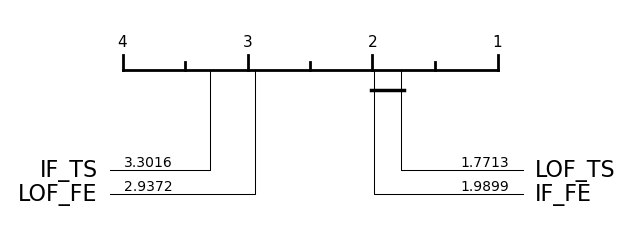

In [56]:
plot_critical_difference(ucr_128.values,  list(ucr_128.columns), alpha=0.05,
                          test="nemenyi", correction=None)   
print("MOYENNE    :", round(ucr_128.mean(axis=0),3).tolist())
print("ECART-TYPE :", round(ucr_128.std(axis=0),3).tolist())

#### Taille de fenêtre 256

MOYENNE    : [0.596, 0.77, 0.76, 0.609]
ECART-TYPE : [0.237, 0.167, 0.204, 0.15]


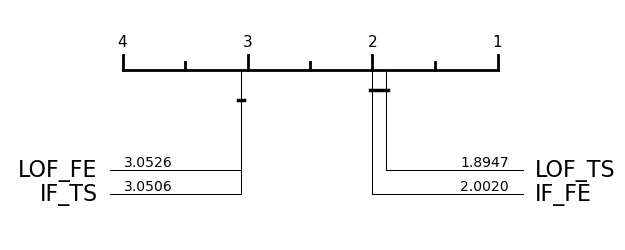

In [57]:
plot_critical_difference(ucr_256.values,  list(ucr_256.columns), alpha=0.05,
                          test="nemenyi", correction=None)   
print("MOYENNE    :", round(ucr_256.mean(axis=0),3).tolist())
print("ECART-TYPE :", round(ucr_256.std(axis=0),3).tolist())